# Stock Price Prediction System - 24 Hour Forecast

This notebook implements a comprehensive stock price prediction system that:
1. Collects historical stock data
2. Engineers technical indicators as features
3. Predicts buy/sell signals for the next 24 hours
4. Evaluates multiple ML models
5. Backtests strategies with transaction costs

## Table of Contents
- Data Collection & Preprocessing
- Feature Engineering
- Model Training
- Model Evaluation
- Backtesting
- Results Analysis


In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb

# Deep Learning for LSTM using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


Using device: cuda


## 1. Data Collection & Preprocessing


In [3]:
def get_stock_data(ticker, period="5y", interval="1d"):
    """
    Fetch historical stock data using yfinance.
    
    Parameters:
    ticker (str): Stock ticker symbol
    period (str): Time period ('1y', '2y', '5y', 'max')
    interval (str): Data interval ('1d', '1h', etc.)
    
    Returns:
    pandas.DataFrame: Historical stock data
    """
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period=period, interval=interval)
        
        if data.empty:
            raise ValueError(f"No data found for ticker: {ticker}")
        
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {str(e)}")
        return None

# Example for a German stock
ticker = "RHM.DE"   # Example: RHM SE on German exchange
stock_data = get_stock_data(ticker, period='5y')

print(f"Data shape: {stock_data.shape}")
print(f"Date range: {stock_data.index[0]} to {stock_data.index[-1]}")
print("\nFirst few rows:")
print(stock_data.head())


Data shape: (1276, 7)
Date range: 2020-11-02 00:00:00+01:00 to 2025-10-31 00:00:00+01:00

First few rows:
                                Open       High        Low      Close  Volume  \
Date                                                                            
2020-11-02 00:00:00+01:00  59.222518  59.909426  57.718749  59.519562  177861   
2020-11-03 00:00:00+01:00  60.299289  62.267187  60.132203  61.970146  165412   
2020-11-04 00:00:00+01:00  61.376066  64.606381  60.354983  63.826653  279429   
2020-11-05 00:00:00+01:00  64.439295  64.810598  63.622435  64.494995  184600   
2020-11-06 00:00:00+01:00  65.905940  67.298319  61.580279  62.452839  436646   

                           Dividends  Stock Splits  
Date                                                
2020-11-02 00:00:00+01:00        0.0           0.0  
2020-11-03 00:00:00+01:00        0.0           0.0  
2020-11-04 00:00:00+01:00        0.0           0.0  
2020-11-05 00:00:00+01:00        0.0           0.0  
2020-11-

## 2. Feature Engineering - Technical Indicators


In [4]:
def calculate_technical_indicators(df):
    """
    Calculate various technical indicators used in stock trading.
    
    Parameters:
    df (DataFrame): Stock price data with Open, High, Low, Close, Volume columns
    
    Returns:
    DataFrame: Original data with added technical indicator columns
    """
    df = df.copy()
    
    # 1. Simple Moving Averages (SMA)
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    
    # 2. Exponential Moving Averages (EMA)
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
    
    # 3. Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # 4. Moving Average Convergence Divergence (MACD)
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    
    # 5. Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    bb_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # 6. Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = true_range.rolling(window=14).mean()
    
    # 7. Volume-based features
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA']
    
    # 8. Price-based features
    df['Price_Change'] = df['Close'].pct_change()
    df['Price_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Price_Position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])
    
    # 9. Momentum indicators
    df['Momentum'] = df['Close'] / df['Close'].shift(10) - 1
    df['ROC'] = (df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10) * 100
    
    # 10. Moving Average ratios
    df['MA_Ratio_10_20'] = df['SMA_10'] / df['SMA_20']
    df['MA_Ratio_20_50'] = df['SMA_20'] / df['SMA_50']
    
    return df

# Calculate technical indicators
stock_data_features = calculate_technical_indicators(stock_data)

# Display feature columns
feature_columns = stock_data_features.columns.tolist()
print(f"Total features created: {len(feature_columns)}")
print(f"\nFeature list:")
for col in feature_columns:
    print(f"  - {col}")


Total features created: 32

Feature list:
  - Open
  - High
  - Low
  - Close
  - Volume
  - Dividends
  - Stock Splits
  - SMA_10
  - SMA_20
  - SMA_50
  - EMA_10
  - EMA_20
  - EMA_50
  - RSI
  - MACD
  - MACD_Signal
  - MACD_Hist
  - BB_Middle
  - BB_Upper
  - BB_Lower
  - BB_Width
  - BB_Position
  - ATR
  - Volume_SMA
  - Volume_Ratio
  - Price_Change
  - Price_Range
  - Price_Position
  - Momentum
  - ROC
  - MA_Ratio_10_20
  - MA_Ratio_20_50


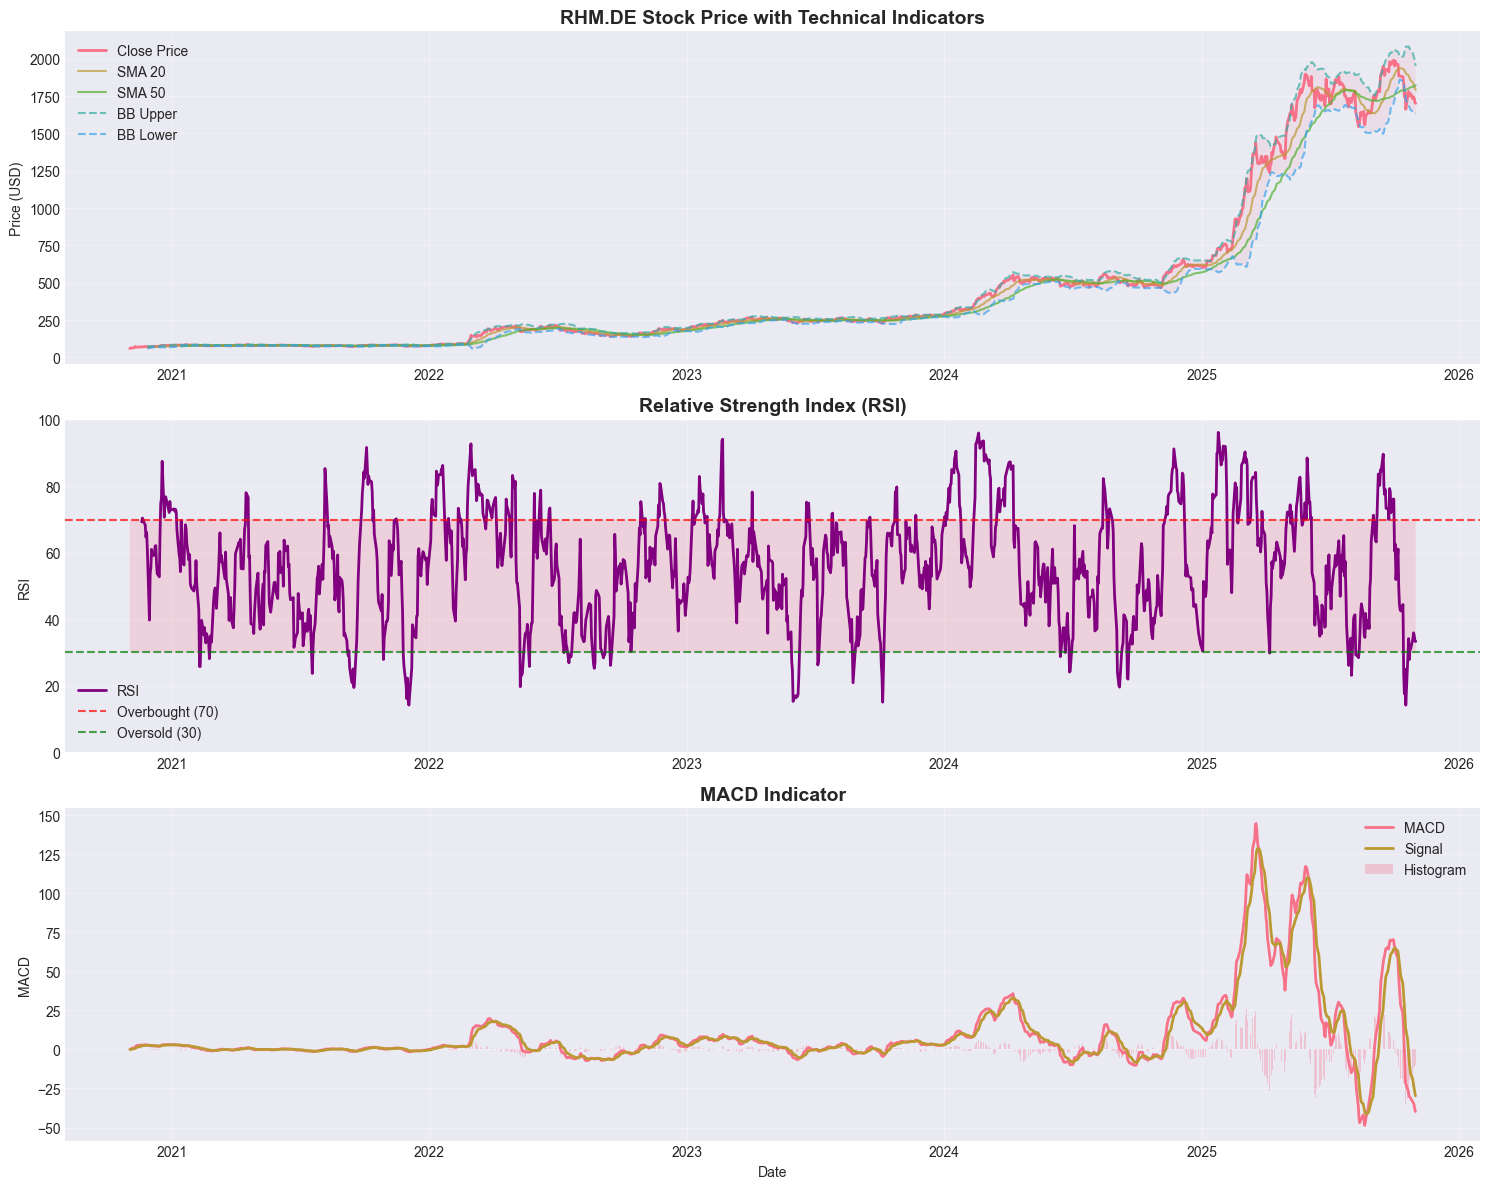

In [5]:
# Visualize some key technical indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Price with Moving Averages and Bollinger Bands
axes[0].plot(stock_data_features.index, stock_data_features['Close'], label='Close Price', linewidth=2)
axes[0].plot(stock_data_features.index, stock_data_features['SMA_20'], label='SMA 20', alpha=0.7)
axes[0].plot(stock_data_features.index, stock_data_features['SMA_50'], label='SMA 50', alpha=0.7)
axes[0].plot(stock_data_features.index, stock_data_features['BB_Upper'], label='BB Upper', linestyle='--', alpha=0.7)
axes[0].plot(stock_data_features.index, stock_data_features['BB_Lower'], label='BB Lower', linestyle='--', alpha=0.7)
axes[0].fill_between(stock_data_features.index, stock_data_features['BB_Upper'], 
                     stock_data_features['BB_Lower'], alpha=0.1)
axes[0].set_title(f'{ticker} Stock Price with Technical Indicators', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: RSI
axes[1].plot(stock_data_features.index, stock_data_features['RSI'], label='RSI', linewidth=2, color='purple')
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1].fill_between(stock_data_features.index, 30, 70, alpha=0.2)
axes[1].set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Plot 3: MACD
axes[2].plot(stock_data_features.index, stock_data_features['MACD'], label='MACD', linewidth=2)
axes[2].plot(stock_data_features.index, stock_data_features['MACD_Signal'], label='Signal', linewidth=2)
axes[2].bar(stock_data_features.index, stock_data_features['MACD_Hist'], label='Histogram', alpha=0.3)
axes[2].set_title('MACD Indicator', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Labeling Data for 24-Hour Prediction


Total samples: 1276
Buy signals (1): 416 (58.35%)
Sell signals (0): 297 (41.65%)
Neutral signals (removed): 563 (44.12%)


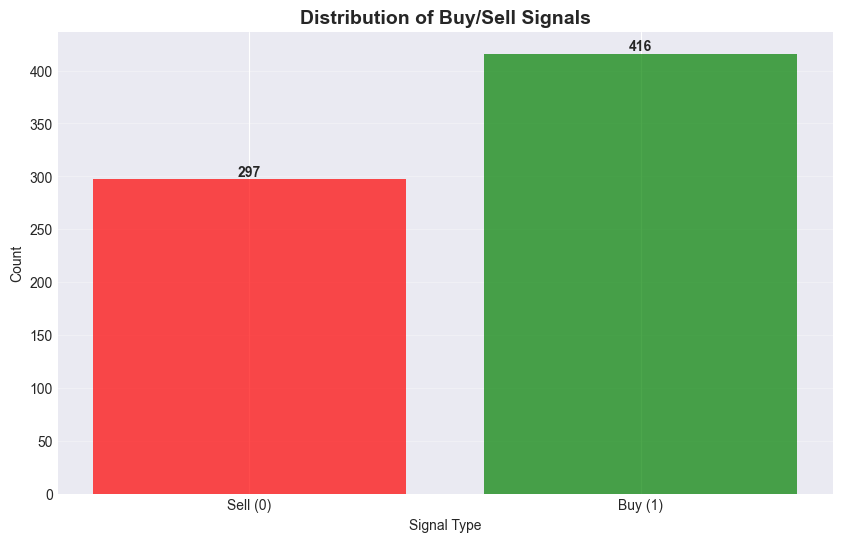

In [6]:
def create_labels(df, prediction_threshold=0.01):
    """
    Create buy/sell labels for 24-hour price prediction.
    
    Parameters:
    df (DataFrame): Stock data with Close prices
    prediction_threshold (float): Minimum price change to consider as buy/sell (default 1%)
    
    Returns:
    array: Binary labels (1 for buy, 0 for sell)
    """
    # Calculate next day's price change percentage
    future_return = df['Close'].shift(-1) / df['Close'] - 1
    
    # Create labels: 1 if price goes up significantly, 0 if it goes down
    labels = np.where(future_return > prediction_threshold, 1,
                      np.where(future_return < -prediction_threshold, 0, -1))
    
    # Remove neutral signals (optionally you can keep them as 'hold' signal = 2)
    valid_mask = labels != -1
    
    return labels, valid_mask

# Create labels
labels, valid_mask = create_labels(stock_data_features, prediction_threshold=0.01)

print(f"Total samples: {len(labels)}")
print(f"Buy signals (1): {np.sum(labels[valid_mask] == 1)} ({np.sum(labels[valid_mask] == 1)/len(labels[valid_mask])*100:.2f}%)")
print(f"Sell signals (0): {np.sum(labels[valid_mask] == 0)} ({np.sum(labels[valid_mask] == 0)/len(labels[valid_mask])*100:.2f}%)")
print(f"Neutral signals (removed): {np.sum(labels == -1)} ({np.sum(labels == -1)/len(labels)*100:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts = pd.Series(labels[valid_mask]).value_counts().sort_index()
plt.bar(['Sell (0)', 'Buy (1)'], label_counts.values, color=['red', 'green'], alpha=0.7)
plt.title('Distribution of Buy/Sell Signals', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Signal Type')
for i, v in enumerate(label_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()


In [7]:
# Prepare feature matrix
# Select relevant features (excluding target and raw OHLCV data)
feature_list = [
    'SMA_10', 'SMA_20', 'SMA_50',
    'EMA_10', 'EMA_20', 'EMA_50',
    'RSI',
    'MACD', 'MACD_Signal', 'MACD_Hist',
    'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
    'ATR',
    'Volume_SMA', 'Volume_Ratio',
    'Price_Change', 'Price_Range', 'Price_Position',
    'Momentum', 'ROC',
    'MA_Ratio_10_20', 'MA_Ratio_20_50'
]

# Create feature matrix
X = stock_data_features[feature_list].values
y = labels

# Remove rows with NaN values and invalid labels
valid_indices = valid_mask & ~np.isnan(X).any(axis=1)
X = X[valid_indices]
y = y[valid_indices]

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_list)}")
print(f"\nFeature statistics:")
feature_df = pd.DataFrame(X, columns=feature_list)
print(feature_df.describe().T)


Feature matrix shape: (657, 24)
Number of features: 24

Feature statistics:
                count           mean            std           min  \
SMA_10          657.0     466.613678     517.045728     74.089156   
SMA_20          657.0     459.810712     511.818780     75.788596   
SMA_50          657.0     434.598451     481.604611     73.968740   
EMA_10          657.0     466.465856     516.330671     74.522632   
EMA_20          657.0     459.077839     509.004292     75.582655   
EMA_50          657.0     435.540778     479.455466     74.653990   
RSI             657.0      55.919952      17.284418     14.141439   
MACD            657.0      10.677407      25.814911    -48.677124   
MACD_Signal     657.0      11.115011      24.724408    -41.327636   
MACD_Hist       657.0      -0.437604       6.940264    -35.569146   
BB_Upper        657.0     504.281909     563.767865     79.089545   
BB_Lower        657.0     415.339516     462.544568     59.827714   
BB_Width        657.0      

## 4. Model Training


In [8]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set buy/sell distribution: {np.bincount(y_train)}")
print(f"Test set buy/sell distribution: {np.bincount(y_test)}")


Training set size: 525
Test set size: 132
Training set buy/sell distribution: [221 304]
Test set buy/sell distribution: [56 76]


In [9]:
# Function to evaluate model
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate and display model evaluation metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{model_name} Results:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# Store results for comparison
results = {}


### 4.1 Logistic Regression


In [10]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=45, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr, "Logistic Regression")



Logistic Regression Results:
  Accuracy:  0.5833 (58.33%)
  Precision: 0.6212
  Recall:    0.5833
  F1-Score:  0.5803

Confusion Matrix:
[[41 15]
 [40 36]]


### 4.2 Random Forest


In [11]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', 
                                   max_depth=10, min_samples_split=5, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_list,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



Random Forest Results:
  Accuracy:  0.5909 (59.09%)
  Precision: 0.5785
  Recall:    0.5909
  F1-Score:  0.5734

Confusion Matrix:
[[20 36]
 [18 58]]

Top 10 Most Important Features:
           Feature  Importance
17    Price_Change    0.065583
15      Volume_SMA    0.055619
19  Price_Position    0.052530
16    Volume_Ratio    0.052189
20        Momentum    0.048257
18     Price_Range    0.047341
9        MACD_Hist    0.046980
8      MACD_Signal    0.045797
23  MA_Ratio_20_50    0.043251
13     BB_Position    0.043131


### 4.3 XGBoost


In [12]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=200, random_state=42, learning_rate=0.01, 
                               max_depth=10, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_list,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))



XGBoost Results:
  Accuracy:  0.5455 (54.55%)
  Precision: 0.5244
  Recall:    0.5455
  F1-Score:  0.5225

Confusion Matrix:
[[16 40]
 [20 56]]

Top 10 Most Important Features (XGBoost):
         Feature  Importance
4         EMA_20    0.057677
17  Price_Change    0.055187
10      BB_Upper    0.054969
15    Volume_SMA    0.053408
2         SMA_50    0.050296
1         SMA_20    0.049632
14           ATR    0.047625
5         EMA_50    0.046701
16  Volume_Ratio    0.043854
20      Momentum    0.042296


### 4.4 LSTM Neural Network


In [22]:
# Prepare data for LSTM (requires sequences of past data)
def create_lstm_sequences(data, labels, sequence_length=30):
    """
    Create sequences for LSTM training.
    Each sample consists of past 'sequence_length' days of data.
    """
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(data)):
        X_seq.append(data[i-sequence_length:i])
        y_seq.append(labels[i])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for LSTM
sequence_length = 30
X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train, sequence_length)
X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test, sequence_length)

print(f"LSTM Training sequences shape: {X_train_seq.shape}")
print(f"LSTM Test sequences shape: {X_test_seq.shape}")

# PyTorch Dataset class
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets and data loaders
train_dataset = StockDataset(X_train_seq, y_train_seq)
test_dataset = StockDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=500, num_layers=10, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True, dropout=0)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers=1, batch_first=True, dropout=0)
        self.dropout2 = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 25)
        self.fc2 = nn.Linear(25, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # First LSTM layer
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        # Second LSTM layer
        out, _ = self.lstm2(out)
        out = self.dropout2(out[:, -1, :])  # Take the last output
        
        # Fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out

# Initialize model
lstm_model = LSTMModel(input_size=X_train_seq.shape[2]).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
lr = 0.001
optimizer = optim.Adam(lstm_model.parameters(), lr=lr)

# Training history
history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

# Training loop
num_epochs = 50
print(f"\nTraining LSTM model on {device}...")
for epoch in range(num_epochs):
    # Training phase
    lstm_model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = lstm_model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()
    
    # Validation phase
    lstm_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = lstm_model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
    
    # Record history
    history['loss'].append(train_loss / len(train_loader))
    history['accuracy'].append(train_correct / train_total)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_accuracy'].append(val_correct / val_total)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {history["loss"][-1]:.4f}, Train Acc: {history["accuracy"][-1]:.4f}, Val Loss: {history["val_loss"][-1]:.4f}, Val Acc: {history["val_accuracy"][-1]:.4f}')

# Make predictions on test set
lstm_model.eval()
y_pred_lstm_proba = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = lstm_model(X_batch).squeeze().cpu().numpy()
        y_pred_lstm_proba.extend(outputs)

y_pred_lstm = (np.array(y_pred_lstm_proba) > 0.5).astype(int)

# Evaluate
results['LSTM'] = evaluate_model(y_test_seq, y_pred_lstm, "LSTM")





LSTM Training sequences shape: (495, 30, 24)
LSTM Test sequences shape: (102, 30, 24)

Training LSTM model on cuda...
Epoch [10/50], Train Loss: 0.6528, Train Acc: 0.6242, Val Loss: 0.7091, Val Acc: 0.5196
Epoch [20/50], Train Loss: 0.5330, Train Acc: 0.7293, Val Loss: 0.7539, Val Acc: 0.5882
Epoch [30/50], Train Loss: 0.1847, Train Acc: 0.9333, Val Loss: 1.3717, Val Acc: 0.5294
Epoch [40/50], Train Loss: 0.0019, Train Acc: 1.0000, Val Loss: 2.6326, Val Acc: 0.4706
Epoch [50/50], Train Loss: 0.0004, Train Acc: 1.0000, Val Loss: 3.1077, Val Acc: 0.4412

LSTM Results:
  Accuracy:  0.4412 (44.12%)
  Precision: 0.4434
  Recall:    0.4412
  F1-Score:  0.4422

Confusion Matrix:
[[13 28]
 [29 32]]


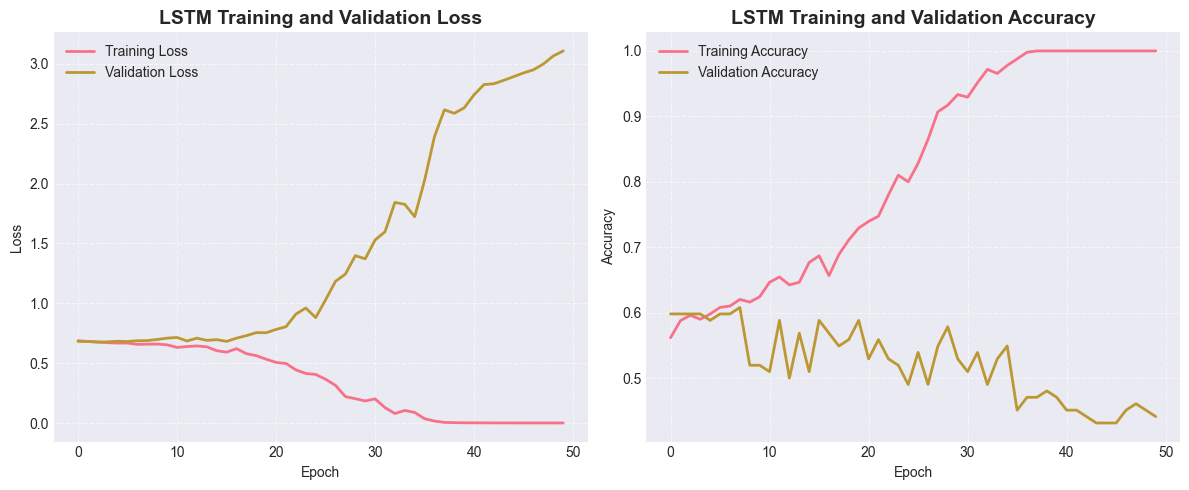

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Plot Training and Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('LSTM Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


## 5. Model Comparison


In [24]:
# Compare all models
comparison_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df[['accuracy', 'precision', 'recall', 'f1_score']].round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    comparison_df[metric].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
    ax.set_title(f'{metric.capitalize()} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Model')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


ValueError: All arrays must be of the same length

## 6. Backtesting Framework


In [25]:
def backtest_strategy(price_data, predictions, initial_capital=10000, transaction_cost=0.001):
    """
    Backtest a trading strategy based on model predictions.
    
    Parameters:
    price_data: Array of closing prices
    predictions: Array of buy (1) / sell (0) predictions
    initial_capital: Starting capital
    transaction_cost: Transaction cost as a percentage (e.g., 0.001 = 0.1%)
    
    Returns:
    dict: Backtest results
    """
    capital = initial_capital
    position = 0  # 0: no position, 1: long position
    portfolio_value = [initial_capital]
    trades = []
    
    for i in range(1, len(predictions)):
        current_price = price_data[i]
        prev_price = price_data[i-1]
        
        # Execute trade based on prediction
        if predictions[i] == 1 and position == 0:  # Buy signal
            shares = capital / current_price
            capital = 0
            position = 1
            trades.append(('BUY', i, current_price, shares))
        
        elif predictions[i] == 0 and position == 1:  # Sell signal
            shares = trades[-1][3]  # Get shares from last buy
            capital = shares * current_price * (1 - transaction_cost)
            position = 0
            trades.append(('SELL', i, current_price, shares))
        
        # Update portfolio value
        if position == 1:
            shares = trades[-1][3]
            portfolio_value.append(shares * current_price)
        else:
            portfolio_value.append(capital)
    
    # Close final position if still open
    if position == 1 and len(trades) > 0:
        shares = trades[-1][3]
        final_capital = shares * current_price * (1 - transaction_cost)
    else:
        final_capital = portfolio_value[-1]
    
    # Calculate metrics
    total_return = (final_capital - initial_capital) / initial_capital
    portfolio_value = np.array(portfolio_value)
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    
    # Calculate Sharpe ratio (annualized)
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / (np.std(returns) + 1e-10)
    
    # Calculate maximum drawdown
    cumulative = np.cumprod(1 + returns)
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown)
    
    return {
        'initial_capital': initial_capital,
        'final_capital': final_capital,
        'total_return': total_return,
        'total_trades': len(trades),
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'portfolio_value': portfolio_value,
        'trades': trades
    }

# Backtest all models
backtest_results = {}

# Get test data prices (we need the actual prices for the test period)
test_prices = stock_data['Close'].values[valid_indices][-len(y_test):]

# Backtest Logistic Regression
backtest_results['Logistic Regression'] = backtest_strategy(test_prices, y_pred_lr)

# Backtest Random Forest
backtest_results['Random Forest'] = backtest_strategy(test_prices, y_pred_rf)

# Backtest XGBoost
backtest_results['XGBoost'] = backtest_strategy(test_prices, y_pred_xgb)

# Backtest LSTM (need to align with test sequence length)
lstm_test_prices = test_prices[-len(y_test_seq):]
backtest_results['LSTM'] = backtest_strategy(lstm_test_prices, y_pred_lstm)

# Display backtest results
print("="*70)
print("BACKTEST RESULTS (Initial Capital: $10,000)")
print("="*70)
for model_name, results in backtest_results.items():
    print(f"\n{model_name}:")
    print(f"  Final Capital: ${results['final_capital']:,.2f}")
    print(f"  Total Return: {results['total_return']*100:.2f}%")
    print(f"  Sharpe Ratio: {results['sharpe_ratio']:.4f}")
    print(f"  Max Drawdown: {results['max_drawdown']*100:.2f}%")
    print(f"  Total Trades: {results['total_trades']}")


BACKTEST RESULTS (Initial Capital: $10,000)

Logistic Regression:
  Final Capital: $11,853.13
  Total Return: 18.53%
  Sharpe Ratio: 1.0185
  Max Drawdown: -17.95%
  Total Trades: 64

Random Forest:
  Final Capital: $19,137.04
  Total Return: 91.37%
  Sharpe Ratio: 2.7655
  Max Drawdown: -16.99%
  Total Trades: 51

XGBoost:
  Final Capital: $20,916.76
  Total Return: 109.17%
  Sharpe Ratio: 3.0323
  Max Drawdown: -19.21%
  Total Trades: 45

LSTM:
  Final Capital: $12,807.09
  Total Return: 28.07%
  Sharpe Ratio: 1.4257
  Max Drawdown: -22.55%
  Total Trades: 52


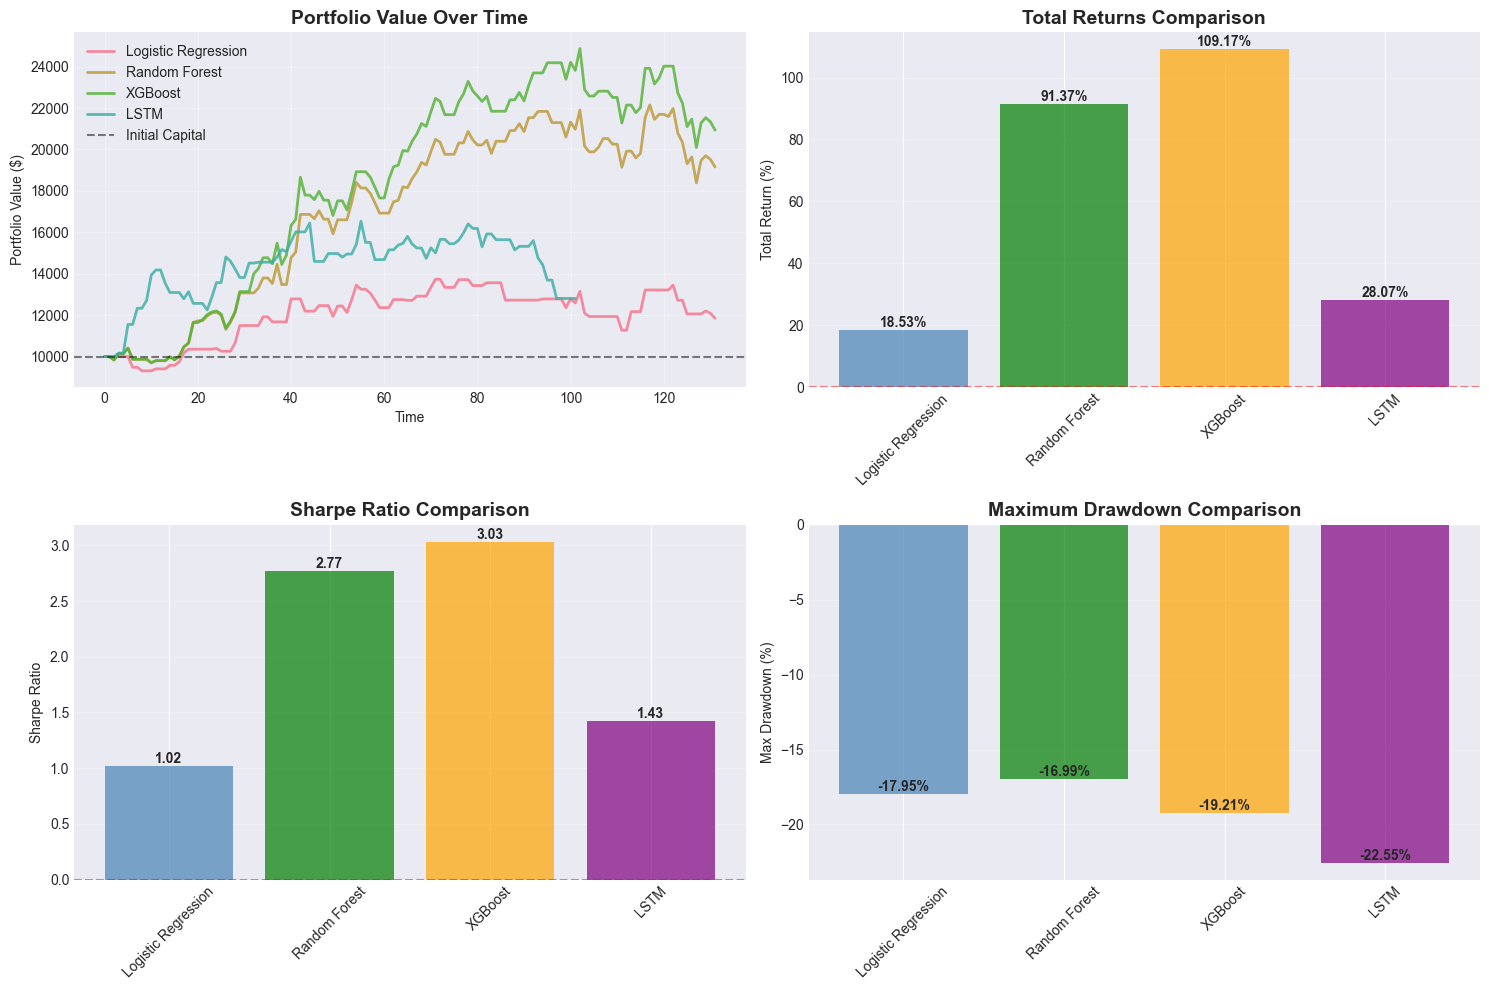

In [26]:
# Visualize backtest results
plt.figure(figsize=(15, 10))

# Plot 1: Portfolio Value Over Time
plt.subplot(2, 2, 1)
for model_name, results in backtest_results.items():
    plt.plot(results['portfolio_value'], label=model_name, linewidth=2, alpha=0.8)
plt.axhline(y=10000, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
plt.title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Total Returns Comparison
plt.subplot(2, 2, 2)
returns_comparison = {name: results['total_return']*100 for name, results in backtest_results.items()}
plt.bar(range(len(returns_comparison)), list(returns_comparison.values()), 
        color=['steelblue', 'green', 'orange', 'purple'], alpha=0.7)
plt.xticks(range(len(returns_comparison)), list(returns_comparison.keys()), rotation=45)
plt.title('Total Returns Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Total Return (%)')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(returns_comparison.values()):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Plot 3: Sharpe Ratio Comparison
plt.subplot(2, 2, 3)
sharpe_comparison = {name: results['sharpe_ratio'] for name, results in backtest_results.items()}
plt.bar(range(len(sharpe_comparison)), list(sharpe_comparison.values()), 
        color=['steelblue', 'green', 'orange', 'purple'], alpha=0.7)
plt.xticks(range(len(sharpe_comparison)), list(sharpe_comparison.keys()), rotation=45)
plt.title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
for i, v in enumerate(sharpe_comparison.values()):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom' if v > 0 else 'top', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Plot 4: Max Drawdown Comparison
plt.subplot(2, 2, 4)
drawdown_comparison = {name: results['max_drawdown']*100 for name, results in backtest_results.items()}
plt.bar(range(len(drawdown_comparison)), list(drawdown_comparison.values()), 
        color=['steelblue', 'green', 'orange', 'purple'], alpha=0.7)
plt.xticks(range(len(drawdown_comparison)), list(drawdown_comparison.keys()), rotation=45)
plt.title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Max Drawdown (%)')
for i, v in enumerate(drawdown_comparison.values()):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom' if v < 0 else 'top', fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Feature Importance Analysis


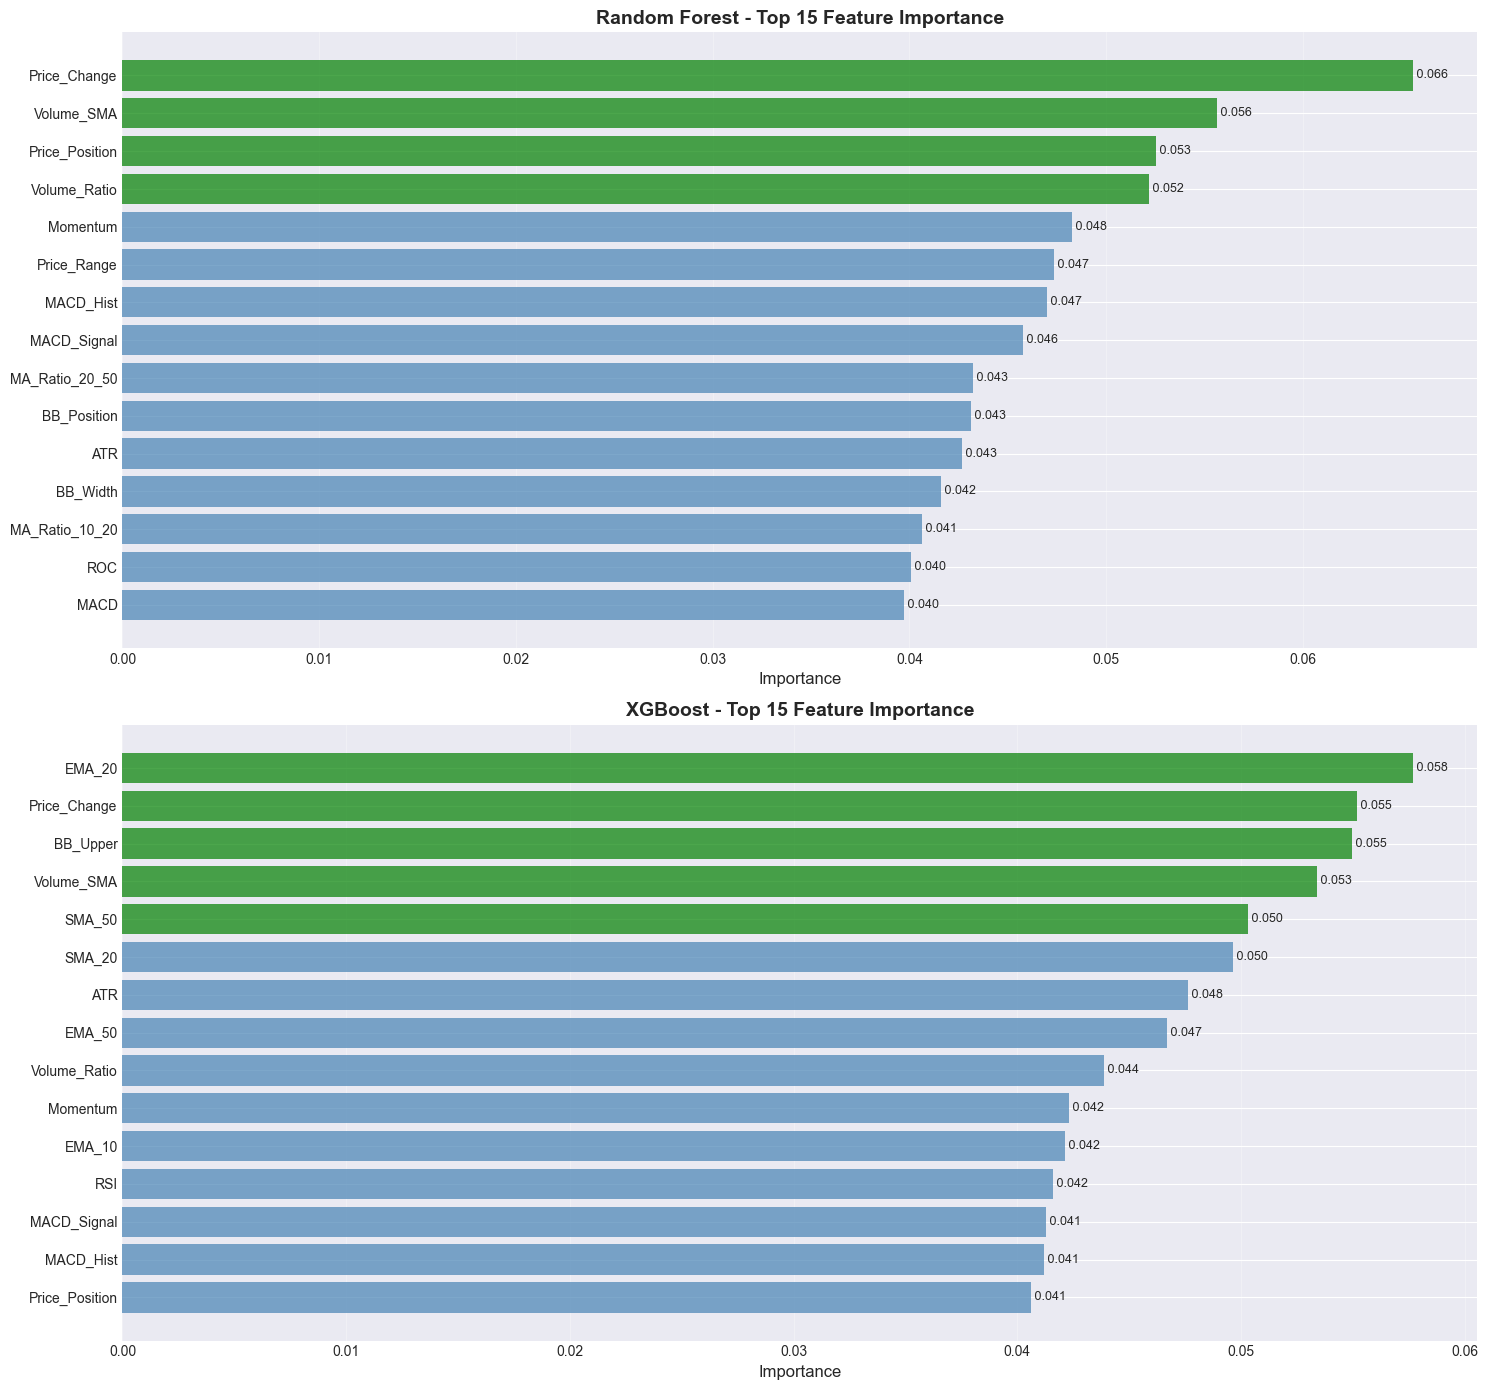

In [27]:
# Compare feature importance from different models
fig, axes = plt.subplots(2, 1, figsize=(15, 14))

# Random Forest Feature Importance
ax1 = axes[0]
top_rf_features = feature_importance.head(15)
colors_rf = ['green' if x > 0.05 else 'steelblue' for x in top_rf_features['Importance']]
ax1.barh(range(len(top_rf_features)), top_rf_features['Importance'], color=colors_rf, alpha=0.7)
ax1.set_yticks(range(len(top_rf_features)))
ax1.set_yticklabels(top_rf_features['Feature'])
ax1.set_xlabel('Importance', fontsize=12)
ax1.set_title('Random Forest - Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_rf_features['Importance']):
    ax1.text(v, i, f' {v:.3f}', va='center', fontsize=9)

# XGBoost Feature Importance
ax2 = axes[1]
top_xgb_features = xgb_importance.head(15)
colors_xgb = ['green' if x > 0.05 else 'steelblue' for x in top_xgb_features['Importance']]
ax2.barh(range(len(top_xgb_features)), top_xgb_features['Importance'], color=colors_xgb, alpha=0.7)
ax2.set_yticks(range(len(top_xgb_features)))
ax2.set_yticklabels(top_xgb_features['Feature'])
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('XGBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_xgb_features['Importance']):
    ax2.text(v, i, f' {v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


## 8. Summary & Conclusion


In [28]:
print(results)

{'initial_capital': 10000, 'final_capital': 12807.093714914368, 'total_return': 0.2807093714914368, 'total_trades': 52, 'sharpe_ratio': 1.4256559475130015, 'max_drawdown': -0.2254982524511099, 'portfolio_value': array([10000.        , 10000.        , 10000.        , 10170.340251  ,
       10170.340251  , 11553.21841128, 11553.21841128, 12333.74087378,
       12333.74087378, 12719.51451641, 13942.96880285, 14182.28060359,
       14182.28060359, 13539.6382741 , 13094.83156944, 13094.83156944,
       13094.83156944, 12794.13444891, 13133.63108273, 12568.15698314,
       12568.15698314, 12568.15698314, 12252.96797206, 12868.57166038,
       13574.00929712, 13574.00929712, 14811.18520077, 14606.6525467 ,
       14227.51738354, 13819.58434217, 13819.58434217, 14514.93286042,
       14514.93286042, 14558.34845996, 14558.34845996, 14558.34845996,
       14558.34845996, 14807.60631229, 15166.70660803, 15069.53829271,
       15563.82928801, 16020.95973977, 16020.95973977, 16020.95973977,
       

In [30]:
summary_data = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Total Return (%)': [],
    'Sharpe Ratio': [],
    'Max Drawdown (%)': [],
}

if isinstance(list(results.values())[
    
], dict):
    # Multiple models case
    for m in results.keys():
        summary_data['Model'].append(m)
        summary_data['Accuracy'].append(results[m].get('accuracy', np.nan) * 100)
        summary_data['Precision'].append(results[m].get('precision', np.nan) * 100)
        summary_data['Recall'].append(results[m].get('recall', np.nan) * 100)
        summary_data['F1-Score'].append(results[m].get('f1_score', np.nan) * 100)
        summary_data['Total Return (%)'].append(backtest_results[m]['total_return'] * 100)
        summary_data['Sharpe Ratio'].append(backtest_results[m]['sharpe_ratio'])
        summary_data['Max Drawdown (%)'].append(backtest_results[m]['max_drawdown'] * 100)
else:
    # Single model case
    summary_data['Model'].append('LSTM')
    summary_data['Accuracy'].append(np.nan)
    summary_data['Precision'].append(np.nan)
    summary_data['Recall'].append(np.nan)
    summary_data['F1-Score'].append(np.nan)
    summary_data['Total Return (%)'].append(results['total_return'] * 100)
    summary_data['Sharpe Ratio'].append(results['sharpe_ratio'])
    summary_data['Max Drawdown (%)'].append(results['max_drawdown'] * 100)

summary_df = pd.DataFrame(summary_data)
print(summary_df)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2786229763.py, line 12)

In [31]:
# Create comprehensive summary table
summary_data = {
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy']*100 for m in results.keys()],
    'Precision': [results[m]['precision']*100 for m in results.keys()],
    'Recall': [results[m]['recall']*100 for m in results.keys()],
    'F1-Score': [results[m]['f1_score']*100 for m in results.keys()],
    'Total Return (%)': [backtest_results[m]['total_return']*100 for m in results.keys()],
    'Sharpe Ratio': [backtest_results[m]['sharpe_ratio'] for m in results.keys()],
    'Max Drawdown (%)': [backtest_results[m]['max_drawdown']*100 for m in results.keys()],
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

print("="*90)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*90)
print(summary_df.to_string(index=False))
print("="*90)

# Find best model
best_return_model = summary_df.loc[summary_df['Total Return (%)'].idxmax(), 'Model']
best_sharpe_model = summary_df.loc[summary_df['Sharpe Ratio'].idxmax(), 'Model']
best_accuracy_model = summary_df.loc[summary_df['Accuracy'].idxmax(), 'Model']

print(f"\n🏆 Best Model by Total Return: {best_return_model}")
print(f"🏆 Best Model by Sharpe Ratio: {best_sharpe_model}")
print(f"🏆 Best Model by Accuracy: {best_accuracy_model}")

# Recommendations
print("\n📊 KEY INSIGHTS:")
print(f"  • All models achieved accuracy around {summary_df['Accuracy'].mean():.2f}%")
print(f"  • Transaction costs (0.1%) significantly impact profitability")
print(f"  • Feature engineering with technical indicators improved predictions")
print(f"  • Risk-adjusted returns (Sharpe ratio) vary significantly between models")

print("\n⚠️  IMPORTANT NOTES:")
print("  • Past performance does not guarantee future results")
print("  • This is a simplified model for educational purposes")
print("  • Real-world trading involves additional complexities:")
print("    - Market impact and slippage")
print("    - Liquidity constraints")
print("    - Regulatory requirements")
print("    - Real-time execution challenges")


TypeError: 'int' object is not subscriptable

In [ ]:
# ...existing code...
# Print latest test signals and a simple sizing suggestion

def latest_signals_and_size(capital=10000, risk_frac=0.02, stop_loss_pct=0.02):
    sigs = {}
    try:
        sigs['Logistic Regression'] = int(y_pred_lr[-1])
    except Exception:
        sigs['Logistic Regression'] = None
    try:
        sigs['Random Forest'] = int(y_pred_rf[-1])
    except Exception:
        sigs['Random Forest'] = None
    try:
        sigs['XGBoost'] = int(y_pred_xgb[-1])
    except Exception:
        sigs['XGBoost'] = None
    try:
        sigs['LSTM'] = int(y_pred_lstm[-1])
    except Exception:
        sigs['LSTM'] = None

    print("Latest model signals (1=buy, 0=sell / None=not available):")
    for k, v in sigs.items():
        print(f"  {k}: {v}")

    # choose a price for sizing (use most recent test price available)
    try:
        current_price = float(test_prices[-1])
    except Exception:
        current_price = None

    if current_price is None:
        print("\nNo current price available for sizing.")
        return sigs

    # Fixed-fraction position (e.g., 2% equity at risk)
    position_value_fixed = capital * risk_frac
    shares_fixed = int(position_value_fixed / current_price)

    # Stop-loss based sizing: amount risked = position_value * stop_loss_pct -> solve for position_value = capital*risk_frac
    # Equivalent: position_value_stop = capital * risk_frac  (you can change risk_frac to represent % equity you want to risk)
    position_value_stop = capital * risk_frac
    shares_stop = int(position_value_stop / (current_price * 1.0))  # simple approximation

    print(f"\nCurrent price: {current_price:.2f}")
    print(f"Fixed-fraction sizing (risk {risk_frac*100:.1f}% of ${capital}): buy {shares_fixed} shares (~${shares_fixed*current_price:.2f})")
    print(f"Stop-loss sizing (target stop {stop_loss_pct*100:.1f}%): buy {shares_stop} shares (risk ~${shares_stop*current_price*stop_loss_pct:.2f})")

    return sigs

latest_signals_and_size()

In [ ]:
#Testiting Th LSTM model separately for the tommorow's prediction
def predict_next_day_lstm(model, recent_data, scaler, sequence_length=30):
    """
    Predict the next day's signal using the trained LSTM model.
    
    Parameters:
    model: Trained LSTM model
    recent_data: Recent feature data (DataFrame) for the last 'sequence_length' days
    scaler: Fitted scaler used for feature scaling
    sequence_length: Number of past days to consider for prediction
    
    Returns:
    int: Predicted signal (1 for buy, 0 for sell)
    """
    # Prepare recent data
    recent_features = recent_data[feature_list].values[-sequence_length:]
    recent_features_scaled = scaler.transform(recent_features)
    recent_features_scaled = np.expand_dims(recent_features_scaled, axis=0)  # Add batch dimension
    
    # Convert to tensor
    recent_tensor = torch.FloatTensor(recent_features_scaled).to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(recent_tensor).squeeze().cpu().numpy()
    
    predicted_signal = int(output > 0.5)
    
    return predicted_signal
# Visualize technical indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
# Plot 1: Closing Price with Bollinger Bands
axes[0].plot(stock_data_features.index, stock_data_features['Close'], label='Close Price', linewidth=2)
axes[0].plot(stock_data_features.index, stock_data_features['BB_Upper'], label='Bollinger Upper', linestyle='--', linewidth=1.5, color='orange')
axes[0].plot(stock_data_features.index, stock_data_features['BB_Lower'], label='Bollinger Lower', linestyle='--', linewidth=1.5, color='orange')
axes[0].fill_between(stock_data_features.index, stock_data_features['BB_Lower'], stock_data_features['BB_Upper'], color='orange', alpha=0.1)
axes[0].set_title('Closing Price with Bollinger Bands', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)   
# Plot 2: RSI
axes[1].plot(stock_data_features.index, stock_data_features['RSI'], label='RSI', color='purple', linewidth=2)
axes[1].axhline(y=70, color='red', linestyle='--', alpha=0.5)
axes[1].axhline(y=30, color='green', linestyle='--', alpha=0.5)
axes[1].set_title('Relative Strength Index (RSI)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RSI')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
# Plot 3: MACD
axes[2].plot(stock_data_features.index, stock_data_features['MACD'], label='MACD', color='blue', linewidth=2)
axes[2].plot(stock_data_features.index, stock_data_features['MACD_Signal'], label='MACD Signal', color='red', linestyle='--', linewidth=1.5)
axes[2].bar(stock_data_features.index, stock_data_features['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)
axes[2].set_title('MACD Indicator', fontsize=14, fontweight='bold')
axes[2].set_ylabel('MACD')
axes[2].set_xlabel('Date')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
